# ***Regresión Logística***

In [1]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import lime.lime_tabular
import time

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:

# =======================
# LOAD DATA
# =======================
file_path = "../Datos_Saber_Pro_Preprocesed.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': np.int64(0), 'A1': np.int64(1), 'A2': np.int64(2), 'B1': np.int64(3), 'B2': np.int64(4)}


In [4]:
# ============================
# PATHS CONFIGURADOS PARA GUARDADO DE OBJETOS
# ============================
model_filename = "../Models/best_RL_model.pkl"
#study_filename = "../Models/optuna_study_RL_nested.pkl"
metrics_filename = "../Metrics/best_RL_metrics.pkl"
fold_metrics_filename = "../Metrics/RL_folds_summary.csv"

In [5]:

# ============================
# EVALUATION FUNCTION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba)
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [6]:
# ============================
# BUILD PIPELINE
# ============================
def build_pipeline(params, numeric_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))]), categorical_features)
    ],
        verbose_feature_names_out=False,
        force_int_remainder_cols=False
        )
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(**params, n_jobs=-1, class_weight='balanced', random_state=SEED))
    ])
    return model

In [7]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [8]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_wrapper, X_train_raw, y_train_raw):
    X_transformed = model_wrapper.preprocessor.transform(X_train_raw)
    feature_names = model_wrapper.preprocessor.get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [9]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features, n_trials=75):
    def objective(trial):
        params = {
            "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
            "C": trial.suggest_float("C", 0.01, 10.0, log=True),
            "solver": trial.suggest_categorical("solver", ["liblinear", "saga"])}
        
        model = build_pipeline(params, numeric_features, categorical_features)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
        scores = []
        
        for train_idx, val_idx in skf.split(X_inner, y_inner):
            X_t, X_v = X_inner.iloc[train_idx], X_inner.iloc[val_idx]
            y_t, y_v = y_inner.iloc[train_idx], y_inner.iloc[val_idx]
            model.fit(X_t, y_t)
            y_pred = model.predict(X_v)
            scores.append(f1_score(y_v, y_pred, average='weighted'))
        return np.mean(scores)

    study = optuna.create_study(direction="maximize", pruner=MedianPruner())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

In [10]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        return best_model, best_metrics

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=outer_cv.get_n_splits(), desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED
        )

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        model = build_pipeline(best_params, numeric_features, categorical_features)
        model.fit(X_tr, y_tr)

        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test,
            "optuna_time": elapsed
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    return best_model, best_metrics

In [11]:
model, metrics = nested_cv(X, y, numeric_features, categorical_features)

In [12]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Sin '
                                                                                            'Dato',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=F...
                                                   'ESTU_HORASSEMANATRABAJA',
                                                   'ESTU_PAGOMATRICULABECA',
                                                   'ESTU_PAGOMATRICULACREDITO',
                                                   'ESTU_PAGOMATRICULAPADRES',
                                                   'ESTU_PAGOMATRICULAPROPIO',
                                                   'ESTU_PRIVADO_LIBERTAD',
                                                   'ESTU_DEPTO_RESIDE',
                                                   'ESTU_DEPTO_PRESENTACION'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LogisticRegression(C=4.423233141122237,
                                    class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='saga'))])

In [13]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.44      0.05      0.08      4912
           1       0.39      0.25      0.30     11151
           2       0.46      0.75      0.57     20223
           3       0.44      0.34      0.38     11565
           4       0.57      0.40      0.47      5306

    accuracy                           0.46     53157
   macro avg       0.46      0.36      0.36     53157
weighted avg       0.45      0.46      0.42     53157



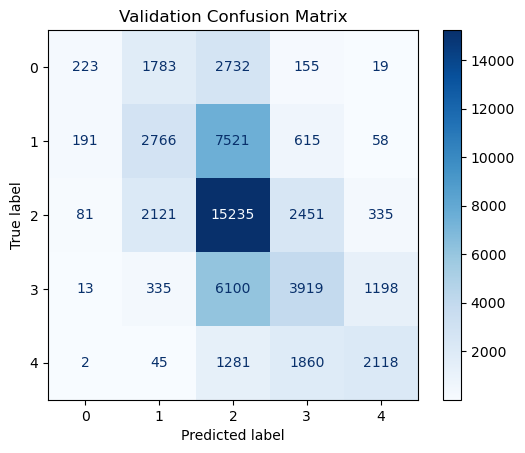

In [14]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [15]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.48      0.05      0.09      6139
           1       0.39      0.25      0.31     13939
           2       0.46      0.75      0.57     25278
           3       0.43      0.34      0.38     14456
           4       0.58      0.41      0.48      6633

    accuracy                           0.46     66445
   macro avg       0.47      0.36      0.36     66445
weighted avg       0.45      0.46      0.42     66445



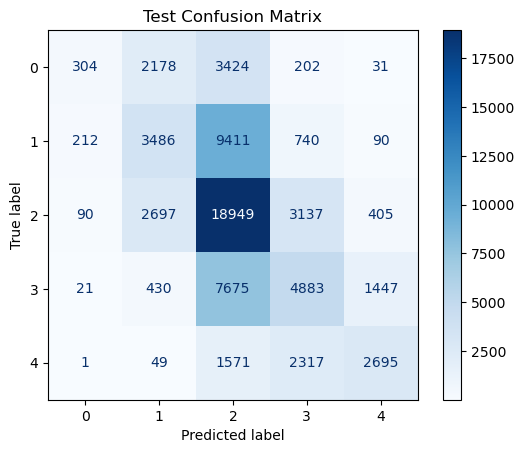

In [16]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

--- Explanation for class 0 ---


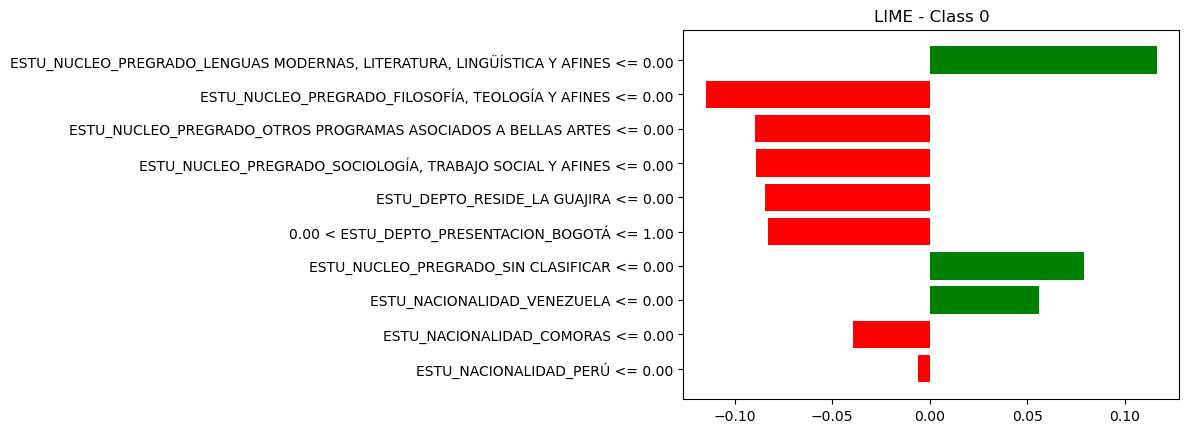

--- Explanation for class 1 ---


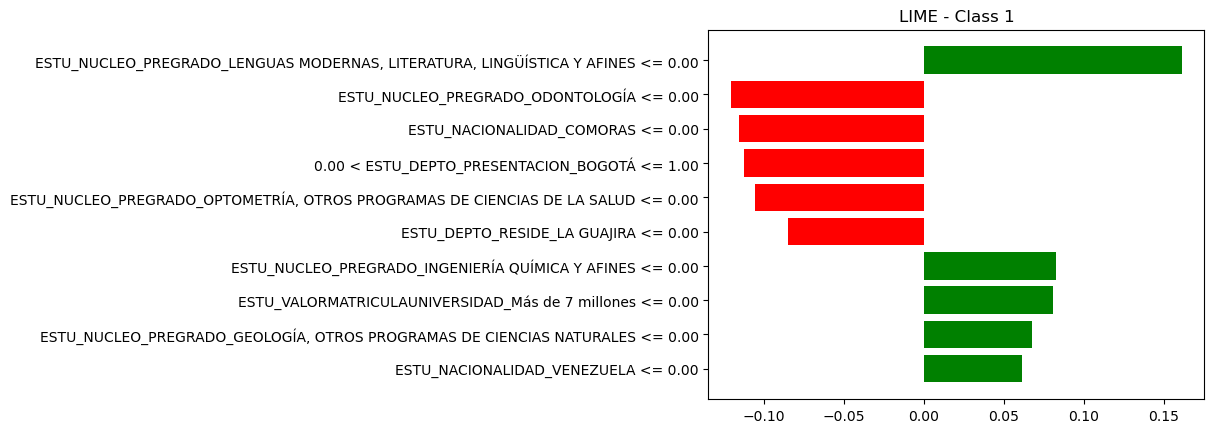

--- Explanation for class 2 ---


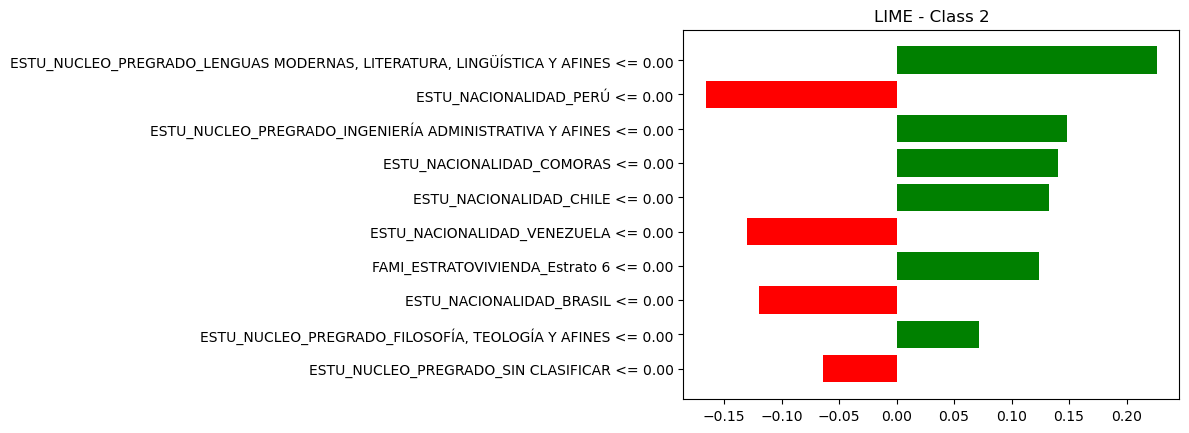

--- Explanation for class 3 ---


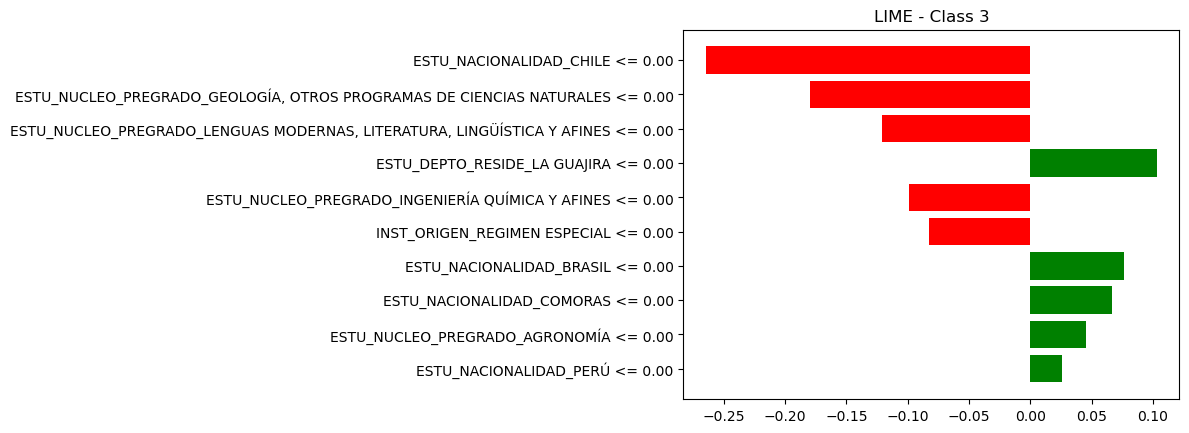

--- Explanation for class 4 ---


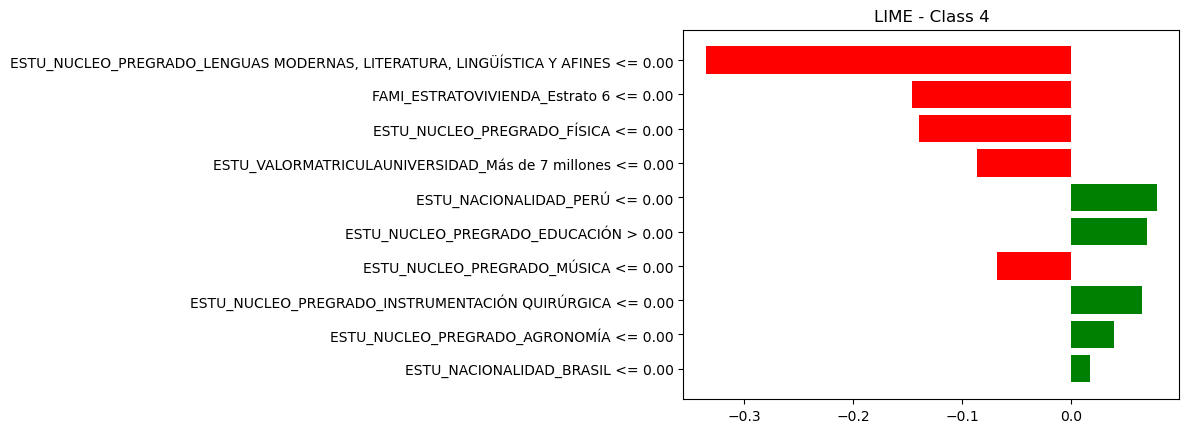

In [17]:
# ============================
# LIME EXPLANATION FOR KNN
# ============================

# Aplicar solo el preprocesamiento
X_transformed = model.named_steps["preprocessor"].transform(metrics['X_train_fold'])

# Función de predicción adaptada: NO volver a preprocesar
def predict_fn(x):
    return model.named_steps["classifier"].predict_proba(x)

# Obtener nombres de features y clases
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

# Instanciar LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Seleccionar instancia
instance = X_transformed[10]

# Explicar
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2, 3, 4])

# Mostrar tabla
exp.show_in_notebook(show_table=True)

# Mostrar gráficas
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [18]:
reporte.save(metrics, model_name="RL")


✅ Report for model 'RL' saved:
   → CSV: ../Metrics/Metrics_RL.csv
   → JSON: ../Metrics/Metrics_RL.json


In [19]:
df = reporte.load()


✅ Loaded 12 report(s):
   → Models: ['LSTM', 'NB_Partial', 'CNN', 'RF', 'RNN', 'Mult_NB', 'CART_SMOTE', 'Bern_NB', 'CART_ADASYN', 'MLP', 'RL', 'CART']
   → Types : ['train', 'val', 'test']


In [20]:
df.query("Model == 'RL' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
240,RL,train,0,0.456,0.046,0.083
241,RL,train,1,0.395,0.246,0.304
242,RL,train,2,0.463,0.751,0.573
243,RL,train,3,0.437,0.343,0.385
244,RL,train,4,0.578,0.411,0.48
245,RL,train,macro avg,0.466,0.36,0.365
246,RL,train,weighted avg,0.454,0.457,0.421


In [21]:
df.query("Model == 'RL' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score
248,RL,val,0,0.437,0.045,0.082
249,RL,val,1,0.392,0.248,0.304
250,RL,val,2,0.464,0.753,0.574
251,RL,val,3,0.435,0.339,0.381
252,RL,val,4,0.568,0.399,0.469
253,RL,val,macro avg,0.459,0.357,0.362
254,RL,val,weighted avg,0.45,0.456,0.419


In [22]:
df.query("Model == 'RL' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score
256,RL,test,0,0.484,0.05,0.09
257,RL,test,1,0.394,0.25,0.306
258,RL,test,2,0.462,0.75,0.572
259,RL,test,3,0.433,0.338,0.379
260,RL,test,4,0.577,0.406,0.477
261,RL,test,macro avg,0.47,0.359,0.365
262,RL,test,weighted avg,0.455,0.456,0.42


In [23]:
df.query("Model == 'RL' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc
247,RL,train,0.457,1.229,0.723
255,RL,val,0.456,1.231,0.722
263,RL,test,0.456,1.233,0.721


In [24]:
df.query("Model == 'RL' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc
255,RL,val,0.456,1.231,0.722


In [25]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


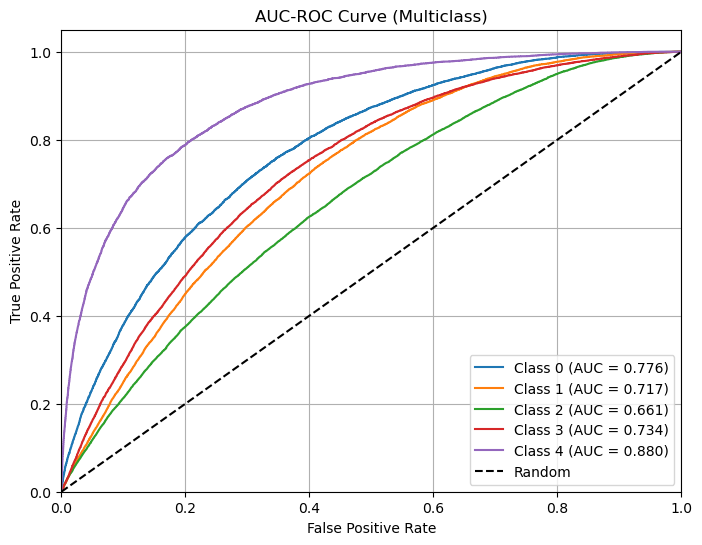

In [26]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [27]:
model.named_steps['classifier'].get_params()

{'C': 4.423233141122237,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}